In [2]:
#Libs
import tensorflow as tf
    
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


In [3]:
dataset_dir = "./dataset/faces"
model_dir   = "./models"
model_name  = "/MobileNetV2.h5"

# Preparing Dataset

In [4]:
# Specify paths to the training and validation dataset directories

BATCH_SIZE = 32
TARGET_SIZE = (160, 160)

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
# Generate batches of tensor image data for training

train_data_generator = data_generator.flow_from_directory(dataset_dir,
                                                               target_size = TARGET_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = "categorical",
                                                               shuffle = False,
                                                               subset = "training")

# Generate batches of tensor image data for validation
validation_data_generator = data_generator.flow_from_directory(dataset_dir,
                                                               target_size = TARGET_SIZE,
                                                               batch_size = BATCH_SIZE,
                                                               class_mode = "categorical",
                                                               shuffle = False,
                                                               subset = "validation")

nb_train_samples = train_data_generator.samples
nb_validation_samples = validation_data_generator.samples

Found 168 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [6]:
class_labels = train_data_generator.class_indices
print(class_labels)

import json

fp = open('class_labels.json', 'w')
json.dump(class_labels, fp)
fp.close()

{'JessicaLuiza': 0, 'LuizFabio': 1}


C:\Users\fabio\anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


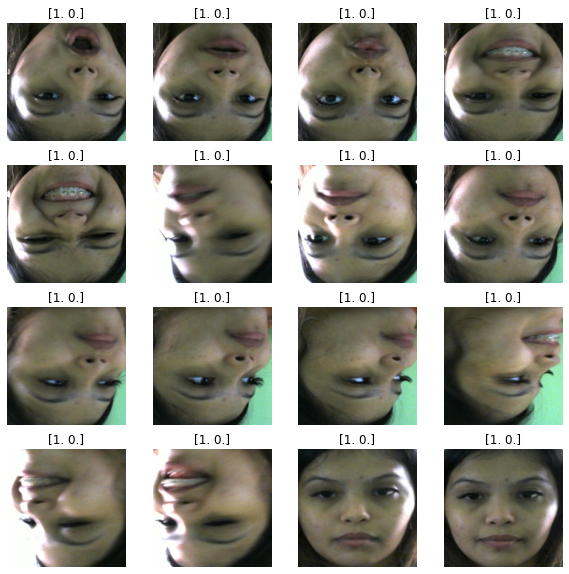

In [7]:
sample_training_images, labels = next(train_data_generator)

def plot_images(images_arr, labels):
    fig, axes = plt.subplots(4, 4 , figsize=(10,10))
    axes = axes.flatten()
    for img, lbs, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbs)
        ax.axis("off")
    plt.tight_layout
    plt.show()

plot_images(sample_training_images[:16], labels[:16])

# Architecture

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

pretrained_model = MobileNetV2(input_shape = input_shape, weights = 'imagenet', include_top = False)
pretrained_model.trainable = False

model = Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(len(class_labels)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8192256   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [9]:
# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor="val_loss", mode='min', verbose = 1, patience = 20)

mc = ModelCheckpoint(model_dir + model_name, monitor = 'val_accuracy', mode = 'max', verbose = 1,
                    save_best_only = True)

In [10]:
# Compile and fit your model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 100

history = model.fit(train_data_generator,
                             steps_per_epoch = train_data_generator.samples/train_data_generator.batch_size,
                             epochs = epochs,
                             validation_data = validation_data_generator,
                             validation_steps = validation_data_generator.samples/validation_data_generator.batch_size,
                             callbacks =[es, mc])

Epoch 1/100
5/5 [==============================] - 5s 514ms/step - loss: 16.6217 - accuracy: 0.5935 - val_loss: 11.7839 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./models\MobileNetV2.h5
Epoch 2/100
5/5 [==============================] - 2s 364ms/step - loss: 9.8742 - accuracy: 0.3805 - val_loss: 1.6220 - val_accuracy: 0.6190

Epoch 00002: val_accuracy improved from 0.50000 to 0.61905, saving model to ./models\MobileNetV2.h5
Epoch 3/100
5/5 [==============================] - 2s 361ms/step - loss: 1.1020 - accuracy: 0.8362 - val_loss: 0.3578 - val_accuracy: 0.9524

Epoch 00003: val_accuracy improved from 0.61905 to 0.95238, saving model to ./models\MobileNetV2.h5
Epoch 4/100
5/5 [==============================] - 2s 324ms/step - loss: 0.3426 - accuracy: 0.9495 - val_loss: 2.8215 - val_accuracy: 0.6429

Epoch 00004: val_accuracy did not improve from 0.95238
Epoch 5/100
5/5 [==============================] - 2s 321ms/step - loss: 0.678

# Evaluation

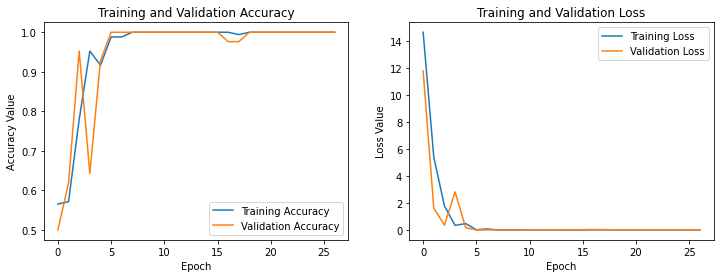

In [11]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Lê o melhor modelo salvo
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model(model_dir + model_name)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(validation_data_generator, nb_validation_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix \n')
print(confusion_matrix(validation_data_generator.classes, y_pred))
print('\n')
print('Classification Report \n')
target_names = class_labels.keys()
print(classification_report(validation_data_generator.classes, y_pred, target_names=target_names))

Confusion Matrix 

[[21  0]
 [ 0 21]]


Classification Report 

              precision    recall  f1-score   support

JessicaLuiza       1.00      1.00      1.00        21
   LuizFabio       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



##### Example test